## ASSIGNMENT 5, QUESTION 1 
### Submitted by Bhanu Bhandari, IEC2016027
#### SPAM OR HAM CLASSIFIER 
Given the instructions in the assignment, all the proper steps have been followed. First, we have explored the dataset and preprocessed it in a manner which gives us only the words and all the other non-useful data has been removed. Then, we create dictionaries of all the words, and then just the **spam** words as well as just the **ham** words. Then, we complete our analysis by finding out the probabilites of particular words belonging to either dataset of spam or ham, and then we try to characterise the message as spam or ham based on their content - each spam/ham word is equally weighted. In the interest of preserving context, stopwords have not been removed. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Text Preprocessing
import nltk
# nltk.download("all")
import string
from nltk.tokenize import word_tokenize

In [3]:
dataset = pd.read_csv("/Users/bhanubhandari/Downloads/spam.csv",encoding='latin-1')

In [4]:
dataset = dataset[["v1","v2"]]

In [41]:
dataset.head()

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
5,spam,freemsg hey darl 3 week word back id like fun ...


In [6]:
dataset = dataset.rename(columns={"v1":"label","v2":"text"})

In [42]:
dataset.head()

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
5,spam,freemsg hey darl 3 week word back id like fun ...


In [8]:
print(dataset.info())
print(dataset.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB
None
ham     4825
spam     747
Name: label, dtype: int64


We now visualise the dataset to see how many words belong to which category. 

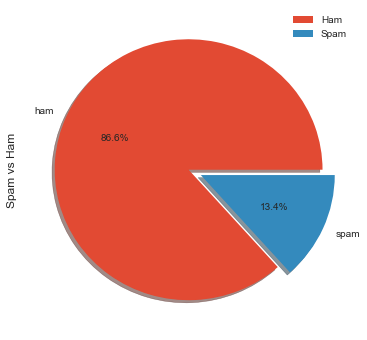

In [9]:
dataset["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

We pick up a few top repeating messages and remove all the duplicates in this case. 

In [43]:
topMessages = dataset.groupby("text")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(n = 10)
display(topMessages)
dataset.drop_duplicates(keep=False, inplace=True)

,len,amax
text,,
,5,ham
contract mobil 11 mnths latest motorola nokia etc free doubl min text orang tariff text yes callback remov record,2,spam
å£400 xmas reward wait comput random pick loyal mobil custom receiv å£400 reward call 09066380611,2,spam
goodmorn today late ltdecimalgt min,2,ham
tri contact repli offer video handset 750 anytim network min unlimit text camcord repli call 08000930705,2,spam
send logo 2 ur lover 2 name join heart txt love name1 name2 mobno eg love adam eve 07123456789 87077 yahoo pobox36504w45wq txtno 4 ad 150p,2,spam
ur chanc win å£250 cash everi wk txt action 80608 tscs wwwmovietriviatv custcar 08712405022 1x150pwk,2,spam
dear 0776xxxxxxx uve invit xchat final attempt contact u txt chat 86688 150pmsgrcvdhgsuite3422landsroww1j6hl ldn 18yr,2,spam
take exam march 3,2,ham


We now start with cleaning up the dataset. We use the comma as a replacement for all the punctuation used in the messages. 

In [11]:
print(dataset.shape)
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english")

def cleanText(message):
    message = message.translate(str.maketrans('', '', string.punctuation))
    words = [stemmer.stem(word) for word in message.split() if word.lower() not in stopwords.words("english")]
    return " ".join(words)

(4888, 2)


In [12]:
dataset["text"] = dataset["text"].apply(cleanText)
dataset = dataset[["label","text"]]
dataset.head()   

,label,text
0,ham,go jurong point crazi avail bugi n great world...
1,ham,ok lar joke wif u oni
3,ham,u dun say earli hor u c alreadi say
4,ham,nah dont think goe usf live around though
5,spam,freemsg hey darl 3 week word back id like fun ...


### NAIVE BAYES CLASSIFICATION 
We now split the data into training and testing subsets and see which data is going into each category. 

In [13]:
def train_test_split(dataset): 
    random_val_msk = np.random.rand(len(dataset)) <= 0.7
    X_train = dataset[random_val_msk]
    X_test = dataset[~random_val_msk]
    return X_train, X_test

In [14]:
dataset_train, dataset_test = train_test_split(dataset)
print(dataset_train.head())
print(dataset_test.head())

   label                                               text
0    ham  go jurong point crazi avail bugi n great world...
1    ham                              ok lar joke wif u oni
3    ham                u dun say earli hor u c alreadi say
10   ham  im gonna home soon dont want talk stuff anymor...
13   ham  ive search right word thank breather promis wo...
   label                                               text
4    ham          nah dont think goe usf live around though
5   spam  freemsg hey darl 3 week word back id like fun ...
6    ham      even brother like speak treat like aid patent
14   ham                                        date sunday
15  spam  xxxmobilemovieclub use credit click wap link n...


In [15]:
mask = np.random.rand(len(dataset))<0.7
text_train = dataset.text[mask].values
text_test = dataset.text[~mask].values
label_train = dataset.label[mask].values
label_test = dataset.label[~mask].values

In [16]:
print(len(text_train),len(text_test),len(label_train),len(label_test))

3419 1469 3419 1469


## CREATING THE DICTIONARIES 
We now create dictionaries of counts of words, first among all the words, then just for the spam words as well as just for the ham words. 

In [19]:
messages = dataset.text.values
words_all = []
for message in messages:
    words_all += (message.split(" "))
unique_words = set(words_all)
dictionary_words = {i:words_all.count(i) for i in unique_words}
dictionary_words['hello']

41

In [20]:
spam_messages = dataset.text.values[dataset.label == "spam"]
spam_words = []
for spam in spam_messages:
    spam_words += (spam.split(" "))
unique_spam_words = set(spam_words)
dictionary_spam = {i:spam_words.count(i) for i in unique_spam_words}
dictionary_spam['win']

35

In [21]:
ham_messages = dataset.text.values[dataset.label == "ham"]
ham_words = []
for ham in ham_messages:
    ham_words += (ham.split(" "))
unique_ham_words = set(ham_words)
dictionary_ham = {i:ham_words.count(i) for i in unique_ham_words}
dictionary_ham['love']

194

In [22]:
total_words = len(words_all)
total_spam = len(spam_words)
total_ham = len(ham_words)
print(total_words, total_spam, total_ham)

44161 9226 34935


## CALCULATING PROBABILITIES AND CLASSIFYING MESSAGES 

In this step, we determine all the probabilities necessary for the classifier to work. We also use 
### LAPLACE SMOOTHING 
to ensure that the problem of zero denominator does not occur. 

In [35]:
def probability_word_given_spam(word):
    return (dictionary_spam[word]/total_spam) 
def probability_word_given_ham(word):
    return dictionary_ham[word]/total_ham 
def probability_word(word):
    try:
        return dictionary_words[word]/total_words
    except KeyError:
        return 0.000000001 
def probability_of_message_being_spam(message):
    num = den = 1
    for word in message.split():
        if word in spam_words:
            num *= probability_word_given_spam(word)
            den *= probability_word(word)
    # This step ensures laplace smoothing 
    if den==0:
        num+=1
        den+=1
    return num/den
def probability_of_message_being_ham(message): 
    num = den = 1
    for word in message.split():
        if word in ham_words:
            num *= probability_word_given_ham(word)
            den *= probability_word(word)
    if den==0:
        num+=1
        den+=1
    return num/den
def spam_predictor(mess):
    if probability_of_message_being_spam(mess) >= probability_of_message_being_ham(mess):
        return "spam"
    else:
        return "ham"

### CONFUSION MATRIX AND ACCURACY DETERMINATION 
We use the above functions to compute the confusion matrix. 

In [38]:
def accuracy_prediction(text_test, label_test):
    false_positive = false_negative = 0 
    true_positive = true_negative = 0
    for i,m in enumerate(text_test):
        predicted = spam_predictor(m)
        actual = label_test[i]
        if predicted == "spam" and actual == "spam":
            true_negative+=1
        if predicted == "spam" and actual == "ham":
            false_negative+=1
        if predicted == "ham" and actual == "spam":
            false_positive+=1
        if predicted == "ham" and actual == "ham":
            true_positive+=1
    accuracy = (true_negative+true_positive)/len(text_test)
    return accuracy, false_positive, false_negative, true_positive, true_negative

In [39]:
acc,fp,fn,tp,tn = accuracy_prediction(text_test,label_test)
print(acc*100, fp,fn,tp,tn)

94.00953029271614 3 85 1217 164


In [40]:
print("True positive: ",tp,"\n False positive: ",fp,"\n False Negative: ",fn,"\n True Negative: ",tn)

True positive:  1217 
 False positive:  3 
 False Negative:  85 
 True Negative:  164


## SUMMARY 
In this assignment, we have explored the usage of the Naive Bayes Classifier in order to detect whether a particular text message is good (ham) or spam. We first picked up raw text messages and cleaned them up in order to have a useful dataset of just words which can be mapped to dictionaries. Then we got rid of all the duplicate text messages, which mostly belonged to the spam category. Once this process was completed, we then calculated the apriori probabilities of words belonging to either category, and determined a threshold for a text message to be categorised as spam or ham. We then compared our predicted results for the testing data with the actual spam/ham values, and found that it performs wonderfully. 